## Import relevant libraries and functions

In [39]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator, 
    perform_experiments,
    Samplers, Constant,
    RealParameter, Scenario
)
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.analysis import (feature_scoring, pairs_plotting)

from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

## Prepare model and parameters

In [40]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2)

# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))
    
problem = get_SALib_problem(uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

## Put experiments and outcomes in a dataframe

In [41]:
with open('experiments_SOBOL_10000xzero', 'rb') as file:
    experiments = pickle.load(file)
    
with open('outcomes_SOBOL_10000xzero', 'rb') as file:
    outcomes = pickle.load(file)

In [42]:
# Store all outcome names in a list
outcome_names = list(outcomes.keys())


## Analyse Sobol indices of non-lever related outcomes

In [43]:
results_dict = {}

for outcome in [outcome_names[i] for i in [0,4]]:
    # Perform the Sobol analysis for each outcome
    Si = sobol.analyze(problem, outcomes[outcome], calc_second_order=True, print_to_console=False)
    
    # Filter the results
    Si_filter = {k: Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
    
    # Create a DataFrame from the filtered results
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])
    
    # Store the DataFrame in the results dictionary
    results_dict[outcome] = Si_df

# Concatenate all the DataFrames in the results dictionary into a single DataFrame
# Use MultiIndex to handle multiple outcomes
final_df = pd.concat(results_dict, axis=1)

# Display the final DataFrame
display(final_df)

C:\Users\Asus\Documents\Python venvs\MBDMv2\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Expected Annual Damage                          \
                                            ST       ST_conf        S1   
A.0_ID flood wave shape           4.803791e-03  2.033558e-04  0.001866   
A.1_Bmax                          1.472935e-02  1.196994e-03  0.004818   
A.1_Brate                         1.279983e-04  2.377000e-05  0.000017   
A.1_pfail                         7.086375e-01  1.200412e-02  0.654341   
A.2_Bmax                          5.694018e-04  1.291175e-04 -0.000019   
A.2_Brate                         2.031096e-05  6.988855e-06 -0.000083   
A.2_pfail                         2.414065e-02  8.781158e-04  0.012027   
A.3_Bmax                          1.678954e-04  3.798734e-05 -0.000009   
A.3_Brate                         1.004680e-05  3.465974e-06 -0.000020   
A.3_pfail                         2.481140e-01  4.913947e-03  0.202684   
A.4_Bmax                          1.429394e-05  5.139267e-06  0.000049   
A.4_Brate                         9.608075e-07  3.617247e-07 -0.000007   
A.4_pfail                         1.298367e-03  1.180263e-04  0.000031   
A.5_Bmax                          0.000000e+00  0.000000e+00  0.000000   
A.5_Brate                         0.000000e+00  0.000000e+00  0.000000   
A.5_pfail                         1.947813e-02  1.034586e-03  0.011610   
discount rate 0                   2.140296e-02  5.718942e-04  0.015221   
discount rate 1                   2.137489e-02  6.839790e-04  0.014625   
discount rate 2                   2.141821e-02  6.294181e-04  0.013285   

                                  Expected Number of Deaths                \
                          S1_conf                        ST       ST_conf   
A.0_ID flood wave shape  0.001465              7.829383e-03  4.225610e-04   
A.1_Bmax                 0.002529              3.636431e-02  3.269912e-03   
A.1_Brate                0.000233              3.291554e-04  6.982989e-05   
A.1_pfail                0.012979              2.855094e-01  6.827736e-03   
A.2_Bmax                 0.000357              1.332516e-03  4.357665e-04   
A.2_Brate                0.000084              3.935096e-05  1.446091e-05   
A.2_pfail                0.003105              2.953929e-02  2.145779e-03   
A.3_Bmax                 0.000231              1.311937e-04  2.860811e-05   
A.3_Brate                0.000059              7.426014e-06  1.943784e-06   
A.3_pfail                0.008526              7.947468e-01  1.439209e-02   
A.4_Bmax                 0.000070              1.168507e-05  3.934730e-06   
A.4_Brate                0.000020              9.389412e-07  4.137177e-07   
A.4_pfail                0.000720              1.143996e-03  1.109547e-04   
A.5_Bmax                 0.000000              0.000000e+00  0.000000e+00   
A.5_Brate                0.000000              0.000000e+00  0.000000e+00   
A.5_pfail                0.003045              1.526984e-02  6.818381e-04   
discount rate 0          0.002986              0.000000e+00  0.000000e+00   
discount rate 1          0.003054              0.000000e+00  0.000000e+00   
discount rate 2          0.003173              0.000000e+00  0.000000e+00   

                                             
                               S1   S1_conf  
A.0_ID flood wave shape  0.001851  0.001578  
A.1_Bmax                 0.007381  0.003764  
A.1_Brate               -0.000022  0.000312  
A.1_pfail                0.172251  0.009591  
A.2_Bmax                 0.000098  0.000606  
A.2_Brate               -0.000076  0.000123  
A.2_pfail                0.003112  0.003142  
A.3_Bmax                -0.000019  0.000230  
A.3_Brate               -0.000016  0.000052  
A.3_pfail                0.668144  0.019342  
A.4_Bmax                 0.000025  0.000066  
A.4_Brate               -0.000013  0.000020  
A.4_pfail               -0.000065  0.000677  
A.5_Bmax                 0.000000  0.000000  
A.5_Brate                0.000000  0.000000  
A.5_pfail                0.007628  0.002472  
discount rate 0        

## Visualise outcomes

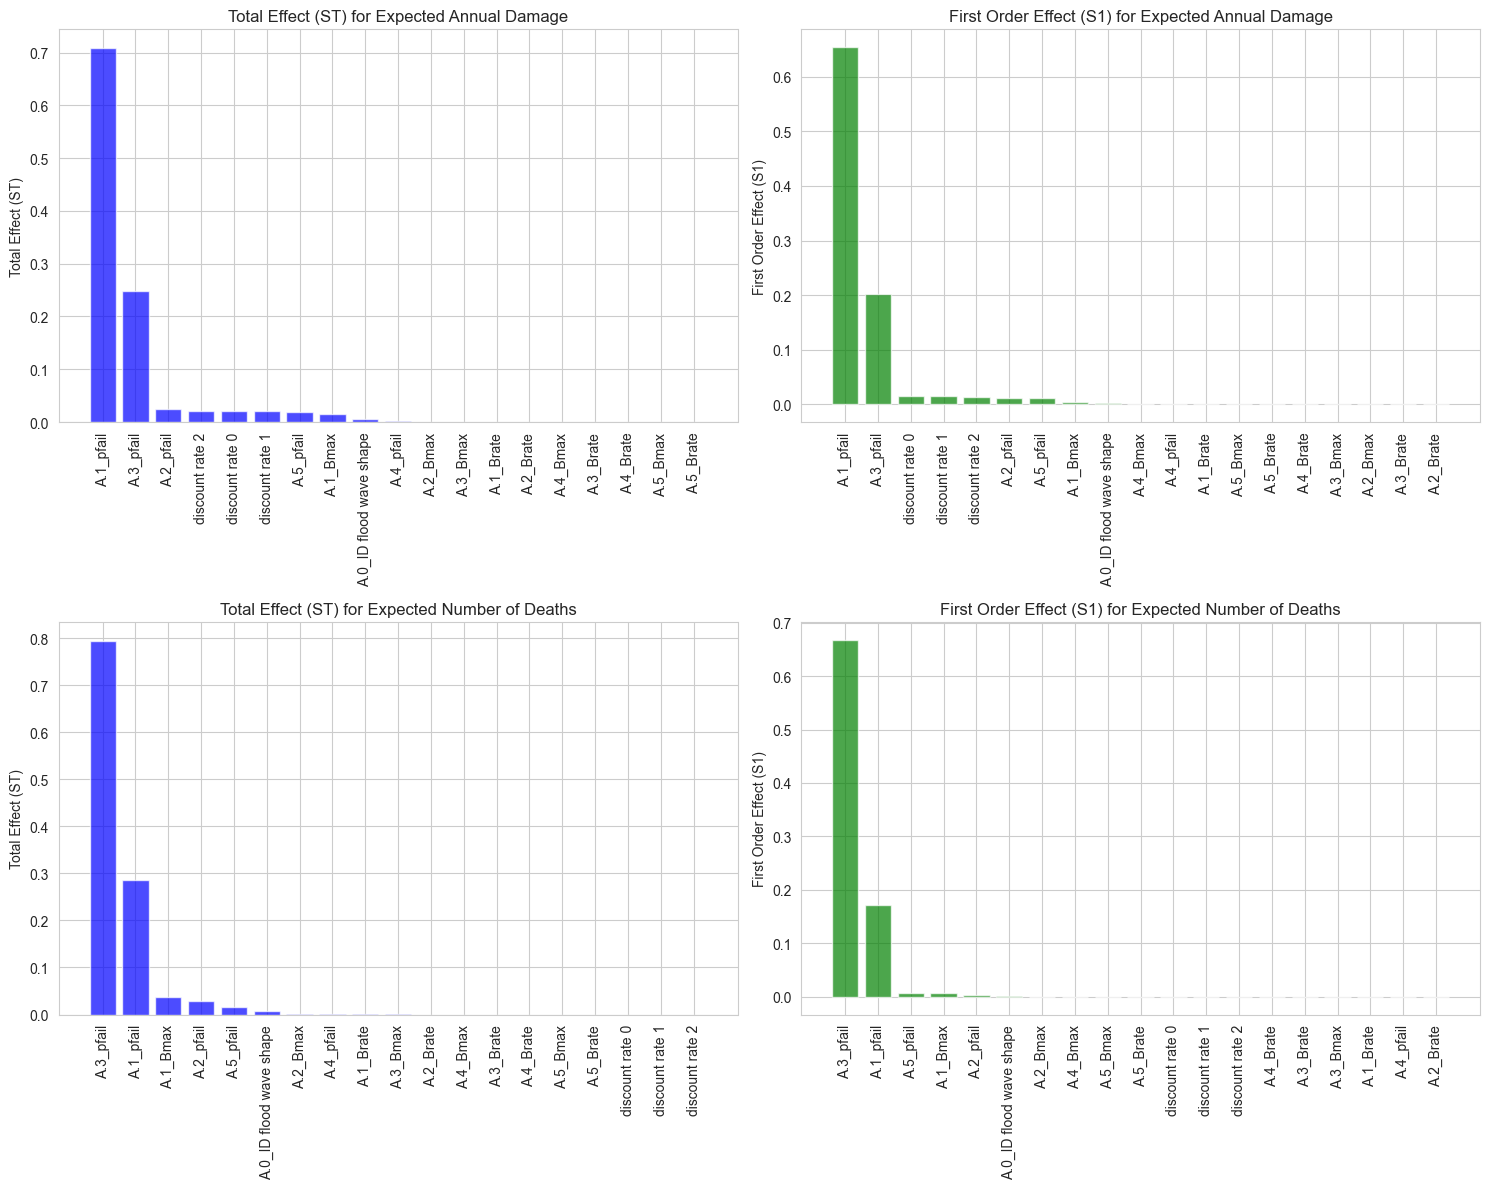

In [44]:
# Extract the unique outcomes from the columns of final_df
outcomes = final_df.columns.get_level_values(0).unique()

# Set the style for seaborn
sns.set_style('whitegrid')

# Create subplots for each outcome
fig, axes = plt.subplots(nrows=len(outcomes), ncols=2, figsize=(15, len(outcomes) * 6))
fig.subplots_adjust(hspace=0.5)

# Iterate over each outcome and plot the ST and S1 values
for i, outcome in enumerate(outcomes):
    # Extract the data for the current outcome
    st_data = final_df[outcome]['ST']
    s1_data = final_df[outcome]['S1']
    
    # Sort the data to identify the uncertainties with the highest effects
    st_sorted = st_data.sort_values(ascending=False)
    s1_sorted = s1_data.sort_values(ascending=False)
    
    # Plot the Total Effects (ST)
    axes[i, 0].bar(st_sorted.index, st_sorted.values, color='b', alpha=0.7)
    axes[i, 0].set_title(f'Total Effect (ST) for {outcome}')
    axes[i, 0].set_ylabel('Total Effect (ST)')
    axes[i, 0].tick_params(axis='x', rotation=90)
    
    # Plot the First Order Effects (S1)
    axes[i, 1].bar(s1_sorted.index, s1_sorted.values, color='g', alpha=0.7)
    axes[i, 1].set_title(f'First Order Effect (S1) for {outcome}')
    axes[i, 1].set_ylabel('First Order Effect (S1)')
    axes[i, 1].tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

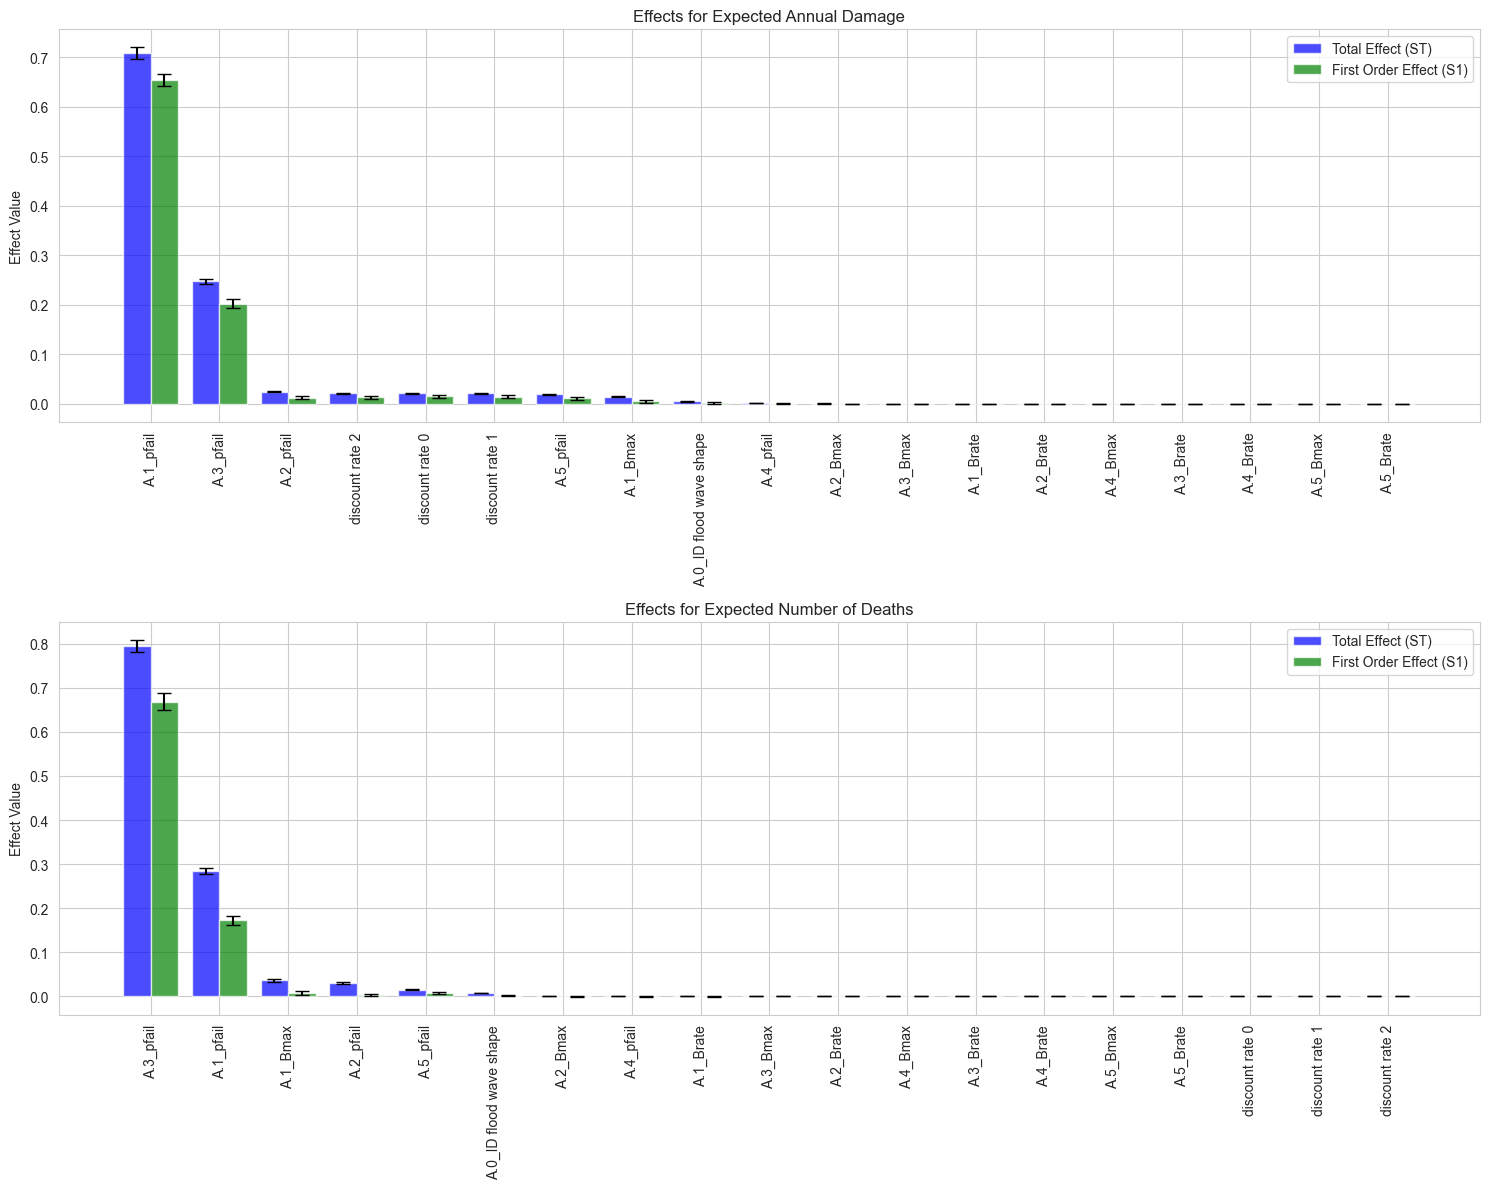

In [45]:
# Extract the unique outcomes from the columns of final_df
outcomes = final_df.columns.get_level_values(0).unique()

# Set the style for seaborn
sns.set_style('whitegrid')

# Create subplots for each outcome
fig, axes = plt.subplots(nrows=len(outcomes), ncols=1, figsize=(15, len(outcomes) * 6))
fig.subplots_adjust(hspace=0.5)

# Define the width of the bars
bar_width = 0.4

# Iterate over each outcome and plot the ST and S1 values side by side
for i, outcome in enumerate(outcomes):
    # Extract the data for the current outcome
    st_data = final_df[outcome]['ST']
    s1_data = final_df[outcome]['S1']
    st_conf = final_df[outcome]['ST_conf']
    s1_conf = final_df[outcome]['S1_conf']
    
    # Sort the data to identify the uncertainties with the highest effects
    indices = st_data.sort_values(ascending=False).index
    st_sorted = st_data.loc[indices]
    s1_sorted = s1_data.loc[indices]
    st_conf_sorted = st_conf.loc[indices]
    s1_conf_sorted = s1_conf.loc[indices]
    
    # Create the positions for the bars
    r1 = np.arange(len(st_sorted))
    r2 = [x + bar_width for x in r1]
    
    # Plot the Total Effects (ST) and First Order Effects (S1) side by side
    ax = axes[i] if len(outcomes) > 1 else axes
    ax.bar(r1, st_sorted.values, yerr=st_conf_sorted.values, width=bar_width, label='Total Effect (ST)', color='b', alpha=0.7, capsize=5)
    ax.bar(r2, s1_sorted.values, yerr=s1_conf_sorted.values, width=bar_width, label='First Order Effect (S1)', color='g', alpha=0.7, capsize=5)
    
    # Set the labels and titles
    ax.set_title(f'Effects for {outcome}')
    ax.set_ylabel('Effect Value')
    ax.set_xticks([r + bar_width/2 for r in range(len(st_sorted))])
    ax.set_xticklabels(indices, rotation=90)
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()